In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tools import add_constant
from statsmodels.regression.rolling import RollingOLS

from backtesting import Backtest

/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
%%time

df = pd.read_csv('/Users/louisspencer/Desktop/Trading-Bot/src/backtest/backtest_data/price_data_1hr.csv', index_col='time_period_end')[['price_open', 'price_high', 'price_low', 'price_close', 'asset_id_base', 'asset_id_quote', 'exchange_id']]
df = df[df.exchange_id.isin(['COINBASE', 'BINANCE', 'GEMINI', 'KRAKEN', 'GATEIO', 'KUCOIN', 'BITFINEX'])]
df['symbol_id'] = df.asset_id_base + '_' + df.asset_id_quote + '_' + df.exchange_id
df.index = pd.to_datetime(df.index)

df.head()

CPU times: user 41.4 s, sys: 18.9 s, total: 1min
Wall time: 1min 41s


,price_open,price_high,price_low,price_close,asset_id_base,asset_id_quote,exchange_id,symbol_id
time_period_end,,,,,,,,
2016-03-09 17:00:00,10.297,10.297,10.097,10.097,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 18:00:00,11.197,11.197,11.197,11.197,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 19:00:00,11.097,11.097,11.097,11.097,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 21:00:00,11.195,11.195,10.660,10.660,ETH,USD,BITFINEX,ETH_USD_BITFINEX
2016-03-09 22:00:00,10.870,11.197,10.870,11.197,ETH,USD,BITFINEX,ETH_USD_BITFINEX


In [9]:
%%time

pivot = df.pivot_table(index = 'time_period_end', columns = 'symbol_id', values = ['price_open', 'price_high', 'price_low', 'price_close'])
pivot.tail()

CPU times: user 5.85 s, sys: 3.88 s, total: 9.73 s
Wall time: 10.9 s


price_close                                  \
symbol_id           1INCH_ETH_GATEIO 88MPH_ETH_GATEIO A5T_ETH_GATEIO   
time_period_end                                                        
2022-09-01 02:00:00         0.000423              NaN       0.000018   
2022-09-01 03:00:00         0.000423              NaN       0.000018   
2022-09-01 04:00:00         0.000423          0.00177       0.000018   
2022-09-01 05:00:00         0.000423          0.00181       0.000018   
2022-09-01 06:00:00         0.000423          0.00179       0.000018   

                                                                      \
symbol_id           AAVE_ETH_BINANCE AAVE_ETH_GATEIO AAVE_ETH_KRAKEN   
time_period_end                                                        
2022-09-01 02:00:00           0.0544          0.0544          0.0545   
2022-09-01 03:00:00           0.0546          0.0544          0.0542   
2022-09-01 04:00:00           0.0544          0.0543             NaN   
2022-09-01 05:00:00           0.0542          0.0542          0.0543   
2022-09-01 06:00:00           0.0543          0.0542          0.0541   

                                                                   \
symbol_id           ABT_ETH_GATEIO ACH_ETH_GATEIO ADA_ETH_BINANCE   
time_period_end                                                     
2022-09-01 02:00:00       0.000089       0.000008        0.000287   
2022-09-01 03:00:00       0.000089       0.000008        0.000288   
2022-09-01 04:00:00       0.000090       0.000008        0.000288   
2022-09-01 05:00:00       0.000090       0.000008        0.000289   
2022-09-01 06:00:00       0.000091       0.000008        0.000289   

                                      ...      price_open                 \
symbol_id           ADA_ETH_COINBASE  ... ZIL_ETH_BINANCE ZIL_ETH_GATEIO   
time_period_end                       ...                                  
2022-09-01 02:00:00         0.000287  ...        0.000023       0.000023   
2022-09-01 03:00:00         0.000288  ...        0.000023       0.000023   
2022-09-01 04:00:00         0.000287  ...        0.000023       0.000023   
2022-09-01 05:00:00         0.000288  ...        0.000023       0.000023   
2022-09-01 06:00:00         0.000288  ...        0.000023       0.000023   

                                                                  \
symbol_id           ZIL_ETH_KUCOIN ZKS_ETH_GATEIO ZPT_ETH_GATEIO   
time_period_end                                                    
2022-09-01 02:00:00       0.000023       0.000036   2.300000e-07   
2022-09-01 03:00:00       0.000023       0.000036   2.270000e-07   
2022-09-01 04:00:00       0.000023       0.000036   2.290000e-07   
2022-09-01 05:00:00       0.000023       0.000036   2.290000e-07   
2022-09-01 06:00:00            NaN       0.000036   2.290000e-07   

                                                                     \
symbol_id           ZRX_ETH_BINANCE ZRX_ETH_BITFINEX ZRX_ETH_GATEIO   
time_period_end                                                       
2022-09-01 02:00:00             NaN         0.000190       0.000190   
2022-09-01 03:00:00             NaN         0.000190       0.000191   
2022-09-01 04:00:00             NaN         0.000191       0.000191   
2022-09-01 05:00:00             NaN         0.000190       0.000190   
2022-09-01 06:00:00             NaN         0.000191       0.000191   

                                                   
symbol_id           ZRX_ETH_KUCOIN ZSC_ETH_GATEIO  
time_period_end                                    
2022-09-01 02:00:00       0.000191   6.200000e-08  
2022-09-01 03:00:00       0.000190   6.100000e-08  
2022-09-01 04:00:00       0.000191   6.100000e-08  
2022-09-01 05:00:00       0.000190   6.200000e-08  
2022-09-01 06:00:00       0.000191   6.200000e-08  

[5 rows x 3168 columns]

In [42]:
%%time

def run_cointegration_for_token(symbol_id, start_date, end_date, p_val_thresh = 0.05):
    
    def convert_to_usd(df, eth):
        if 'ETH_USD' in df.columns[0]:
            return df
        
        m = df.merge(eth, on = 'time_period_end', how = 'inner')
        m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
        return m[df.columns[0]].to_frame()
    
    cointegrated_tokens = []
    
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
        
    eth = pivot['price_close']['ETH_USD_COINBASE'].dropna()
    eth_index = np.array(eth.index.to_list())
    eth = eth[(eth_index >= start_date) & (eth_index <= end_date)].to_frame()
    
    token_data = pivot['price_close'][symbol_id].dropna()
    token_data_index = np.array(token_data.index.to_list())
    token_data = token_data[(token_data_index >= start_date) & (token_data_index <= end_date)].to_frame()
    token_data = convert_to_usd(token_data, eth)
        
    unique_pairs = np.unique([p[1] for p in pivot.columns])
    
    for pair in unique_pairs:
        if 'ETH_USD' in pair or pair == symbol_id:
            continue
            
        price_data = pivot['price_close'][pair].dropna()
        price_data_index = np.array(price_data.index.to_list())
        price_data = price_data[(price_data_index >= start_date) & (price_data_index <= end_date)].to_frame()
        price_data = convert_to_usd(price_data, eth)
        
        m = price_data.merge(token_data, on = 'time_period_end', how = 'inner')
        
        if len(m) == 0:
            continue
            
        X = m[symbol_id]
        X = add_constant(X)
        
        Y = m[pair]
        Y = add_constant(Y)
                
        ols1 = sm.OLS(Y[pair], X).fit()
        ols2 = sm.OLS(X[symbol_id], Y).fit()
        
        best_ols = min([ols1, ols2], key = lambda x: adfuller(x.resid)[1])
        best_p_val = adfuller(best_ols.resid)[1]
        
        if best_ols == ols1 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':symbol_id,
                'Y':pair
            }
            cointegrated_tokens.append(coint_dict)
            
        elif best_ols == ols2 and best_p_val <= p_val_thresh:
            coint_dict = {
                'start':m.index[0],
                'end':m.index[-1],
                'X':pair,
                'Y':symbol_id
            }
            cointegrated_tokens.append(coint_dict)
                    
    return cointegrated_tokens
                

cointegrated_tokens = run_cointegration_for_token(
    'ETH_USD_COINBASE', 
    start_date = '2021-09-01',
    end_date = '2022-09-01'
)


/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


CPU times: user 10min 26s, sys: 16.9 s, total: 10min 43s
Wall time: 1min 25s


In [43]:
cointegrated_tokens

[{'start': Timestamp('2022-07-01 01:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': '1INCH_ETH_GATEIO',
  'Y': 'ETH_USD_COINBASE'},
 {'start': Timestamp('2022-07-01 05:00:00'),
  'end': Timestamp('2022-08-30 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': '88MPH_ETH_GATEIO'},
 {'start': Timestamp('2022-07-01 09:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'A5T_ETH_GATEIO'},
 {'start': Timestamp('2022-07-02 18:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'AAVE_ETH_GATEIO'},
 {'start': Timestamp('2022-07-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'ACH_ETH_GATEIO'},
 {'start': Timestamp('2022-07-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'ETH_USD_COINBASE',
  'Y': 'ADX_ETH_GATEIO'},
 {'start': Timestamp('2022-07-01 00:00:00'),
  'end': Timestamp('2022-09-01 00:00:00'),
  'X': 'AE_ETH_GATEIO',
  'Y': 'ETH_USD_COINBASE'},
 {'start'

In [44]:
def convert_to_usd(df, eth):
    if 'ETH_USD' in df.columns[0]:
        return df

    m = df.merge(eth, on = 'time_period_end', how = 'inner')
    m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
    return m[df.columns[0]].to_frame()
    
eth = pivot['price_close']['ETH_USD_COINBASE'].dropna()

X = pivot['price_close']['ETH_USD_COINBASE'].dropna().to_frame()
X = convert_to_usd(X, eth)

Y = pivot['price_close']['QNT_ETH_GATEIO'].dropna().to_frame()
Y = convert_to_usd(Y, eth)

m = X.merge(Y, on = 'time_period_end', how = 'inner')
m = m[(m.index >= '2022-07-01') & (m.index <= '2022-09-01')]

rolling_hedge_ratios = (
    RollingOLS(
        endog = m[Y.columns[0]], 
        exog = add_constant(m[X.columns[0]]),
        window = 6
    )
).fit().params[X.columns[0]]
    
rolling_spread = m[Y.columns[0]] - rolling_hedge_ratios * m[X.columns[0]]

rolling_mean = rolling_spread.rolling(window = 12).mean()
rolling_std = rolling_spread.rolling(window = 12).std()
rolling_z_score = (rolling_spread - rolling_mean) / rolling_std

Text(0.5, 0, '')

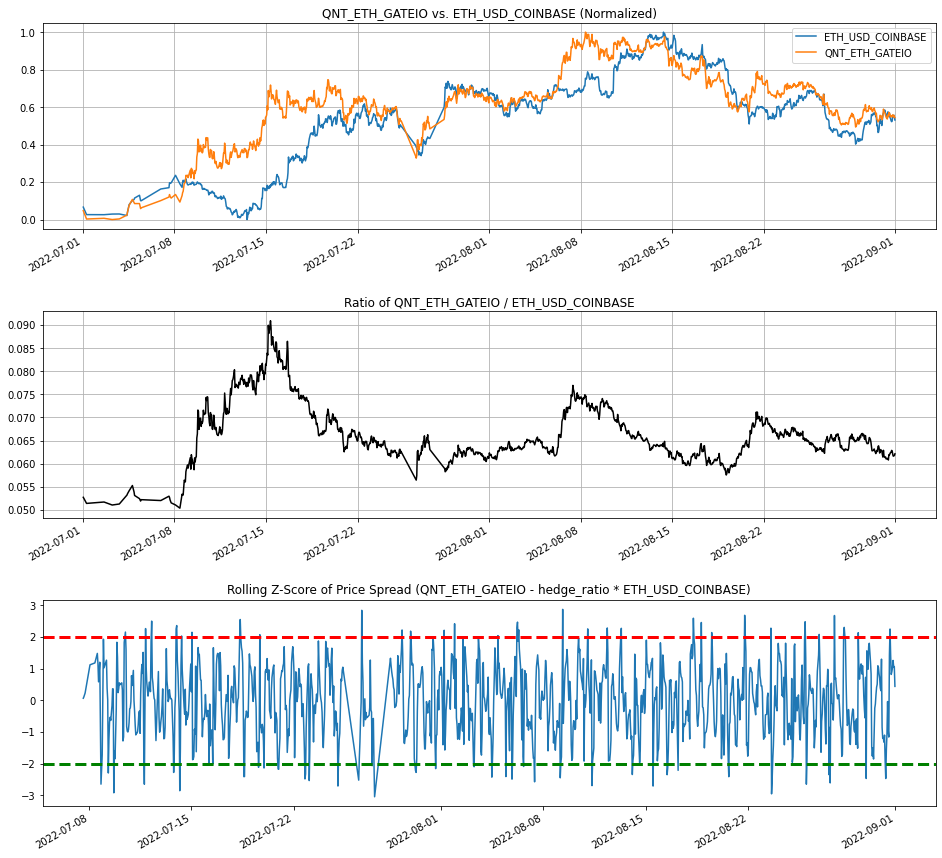

In [45]:
fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 16))
fig.subplots_adjust(hspace=.4)

x = m[X.columns[0]]
y = m[Y.columns[0]]
z = rolling_z_score

plt.subplot(3, 1, 1)
((x - x.min()) / (x.max() - x.min())).plot(label = X.columns[0])
((y - y.min()) / (y.max() - y.min())).plot(label = Y.columns[0], grid = True)
plt.title('{} vs. {} (Normalized)'.format(Y.columns[0], X.columns[0]))
plt.legend()
plt.xlabel('')

plt.subplot(3, 1, 2)
(y / x).plot(title = 'Ratio of {} / {}'.format(Y.columns[0], X.columns[0]), c = 'black', grid = True)
plt.xlabel('')

plt.subplot(3, 1, 3)
z.plot(title = 'Rolling Z-Score of Price Spread ({} - hedge_ratio * {})'.format(Y.columns[0], X.columns[0]))
plt.axhline(-2, c = 'green', linestyle = '--', lw = 3)
plt.axhline(2, c = 'red', linestyle = '--', lw = 3)
plt.xlabel('')

In [76]:
from backtesting import Strategy
from backtesting.lib import crossover, cross

import pandas as pd
import numpy as np

class PairsTrading(Strategy):
    ########### INDICATOR PARAMETERS ##################
    z_window = 72
    hedge_ratio_window = 72
    
    z_thresh_upper = 3
    z_thresh_lower = -2
    
    X = 'ETH_USD_COINBASE'
    Y = 'QNT_ETH_GATEIO'
    ###################################################
        
    def z(data, window):
        data = pd.Series(data)
        return (data - data.rolling(window = window).mean()) / data.rolling(window = window).std()
    
    def h(self, window):
        
        X = pd.DataFrame(add_constant(self.data[PairsTrading.X]))
        X = X.rename({0:'intercept', 1:PairsTrading.X}, axis = 1)
        Y = pd.DataFrame(self.data[PairsTrading.Y])
        
        rolling_hedge_ratio = RollingOLS(
            endog = Y, 
            exog = X, 
            window = self.hedge_ratio_window).fit().params[PairsTrading.X]
        
        return rolling_hedge_ratio
    
    def s(self, h):
        return self.data[PairsTrading.Y] - h * self.data[PairsTrading.X]

    def name():
        return 'PairsTrading'

    def update_hyperparameters(params_dict):
        for param_name, optimal_param_value in params_dict.items():
            setattr(PairsTrading, param_name, optimal_param_value)

    def init(self):
        # Initiate parent classes
        super().init()
        
        # Define indicator value arrays
        
        self.rolling_hedge_ratio = self.I(
            self.h,
            self.hedge_ratio_window
        )
        
        self.spread = self.I(
            self.s,
            self.rolling_hedge_ratio.flatten()
        )

        self.rolling_spread_z_score = self.I(
            PairsTrading.z,
            self.spread.flatten(),
            self.z_window
        )
        
    # Define how the backtest acts at each step of iterating through the dataset
    def next(self): 
        entry_signal = (self.rolling_spread_z_score[-2] > self.z_thresh_lower) and (self.rolling_spread_z_score[-1] < self.z_thresh_lower)
        exit_signal = (self.rolling_spread_z_score[-2] < self.z_thresh_upper) and (self.rolling_spread_z_score[-1] > self.z_thresh_upper)
                
        # Close position
        if (self.position and exit_signal):
            self.position.close()

        # Open position
        elif (not self.position) and entry_signal:
            self.buy(size = 0.5)
                        

In [77]:
backtest_result_cols = [
    '_strategy',
    'Start', 'End', 'Duration', 'Equity Final [$]', 
    'Return [%]', 'Buy & Hold Return [%]', 'Sharpe Ratio', 'Sortino Ratio', 
    'Calmar Ratio', 'Max. Drawdown [%]', 'Avg. Drawdown [%]', 'Max. Drawdown Duration',
    'Avg. Drawdown Duration', '# Trades', 'Win Rate [%]', 'Avg. Trade [%]', 
    'Best Trade [%]', 'Worst Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration', '_equity_curve'
]

In [78]:
open_x = convert_to_usd(pivot['price_open'][X.columns[0]].dropna().to_frame(), eth)
open_y = convert_to_usd(pivot['price_open'][Y.columns[0]].dropna().to_frame(), eth)
merge_open = open_x.merge(open_y, on = 'time_period_end', how = 'inner')
open_ratio =  merge_open[Y.columns[0]] / merge_open[X.columns[0]]

high_x = convert_to_usd(pivot['price_high'][X.columns[0]].dropna().to_frame(), eth)
high_y = convert_to_usd(pivot['price_high'][Y.columns[0]].dropna().to_frame(), eth)
merge_high = high_x.merge(high_y, on = 'time_period_end', how = 'inner')
high_ratio =  merge_high[Y.columns[0]] / merge_high[X.columns[0]]

low_x = convert_to_usd(pivot['price_low'][X.columns[0]].dropna().to_frame(), eth)
low_y = convert_to_usd(pivot['price_low'][Y.columns[0]].dropna().to_frame(), eth)
merge_low = low_x.merge(low_y, on = 'time_period_end', how = 'inner')
low_ratio =  merge_low[Y.columns[0]] / merge_low[X.columns[0]]

close_x = convert_to_usd(pivot['price_close'][X.columns[0]].dropna().to_frame(), eth)
close_y = convert_to_usd(pivot['price_close'][Y.columns[0]].dropna().to_frame(), eth)
merge_close = close_x.merge(close_y, on = 'time_period_end', how = 'inner')
close_ratio =  merge_close[Y.columns[0]] / merge_close[X.columns[0]]

In [136]:
backtest_data = pd.DataFrame(index = merge_open.index, columns = ['Open', 'High', 'Low', 'Close'])
backtest_data_index = np.array(backtest_data.index.to_list())

backtest_data['Open'] = open_ratio
backtest_data['High'] = high_ratio
backtest_data['Low'] = low_ratio
backtest_data['Close'] = close_ratio

backtest_data[X.columns[0]] = X[X.columns[0]]
backtest_data[Y.columns[0]] = Y[Y.columns[0]]

backtest_data = backtest_data[(backtest_data.index >= '2022-07-01') & (backtest_data.index <= '2022-09-01')]
backtest_data.index = pd.to_datetime(backtest_data.index)

In [80]:
%%time

optimize_dict = {
    'z_window':[6, 12, 24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7],
    'hedge_ratio_window':[6, 12, 24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7],
    'z_thresh_upper':[1.5, 2, 2.5, 3],
    'z_thresh_lower':[-1.5, -2, -2.5, -3]
}

in_sample_backtest = Backtest(
    data = backtest_data,
    strategy = PairsTrading,
    cash = 10000,
    commission = 0.01,
    trade_on_close = True
)

stats_for_strat = in_sample_backtest.optimize(
    **optimize_dict,
    maximize = 'Equity Final [$]'
)

buy_and_hold_x = (backtest_data[PairsTrading.X].iloc[-1] - backtest_data[PairsTrading.X].iloc[0]) / backtest_data[PairsTrading.X].iloc[0]
buy_and_hold_x = round(buy_and_hold_x * 100, 2)

buy_and_hold_y = (backtest_data[PairsTrading.Y].iloc[-1] - backtest_data[PairsTrading.Y].iloc[0]) / backtest_data[PairsTrading.Y].iloc[0]
buy_and_hold_y = round(buy_and_hold_y * 100, 2)

max_buy_and_hold = max(buy_and_hold_x, buy_and_hold_y)


/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1296 configurations.
  output = _optimize_grid()
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Ratio'] = np.clip((annualized_return - risk_free_rate) / (np.sqrt(np.mean(day_returns.clip(-np.inf, 0)**2)) * np.sqrt(annual_trading_days)), 0, np.inf)  # noqa: E501
/Users/louisspencer/.pyenv/versions/3.10.0/lib/python3.10/site-packages/backtesting/_stats.py:122: RuntimeWarning: divide by zero encountered in double_scalars
  s.loc['Sortino Rati

CPU times: user 2min 54s, sys: 384 ms, total: 2min 55s
Wall time: 1min 27s


In [81]:
in_sample_backtest.plot(
    results = stats_for_strat, 
    open_browser = False,
    filename = '/Users/louisspencer/Desktop/{}_{}.html'.format
    (PairsTrading.Y, PairsTrading.X),
    reverse_indicators = True,
    plot_equity = False,
    plot_return = True
)

Row(id='2815', ...)

In [82]:
stats_for_strat['Buy & Hold Return [%]'] = max_buy_and_hold
stats_for_strat = stats_for_strat.T.to_frame()
stats_for_strat

,0
Start,2022-07-01 01:00:00
End,2022-09-01 00:00:00
Duration,61 days 23:00:00
Exposure Time [%],23.663522
Equity Final [$],11652.686022
Equity Peak [$],11652.686022
Return [%],16.52686
Buy & Hold Return [%],67.38
Return (Ann.) [%],142.576825
Volatility (Ann.) [%],62.688308


In [135]:
%%time

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import time

from statsmodels.regression.rolling import RollingOLS
from statsmodels.tools import add_constant
from backtesting.lib import crossover, cross

class PairsTradingBacktester:

    z_window = 168
    hedge_ratio_window = 48
    z_score_upper_thresh = 2
    z_score_lower_thresh = -2

    def __init__(self, 
                 symbol_id_1, 
                 symbol_id_2, 
                 start_date, 
                 end_date, 
                 initial_capital = 10_000, 
                 pct_capital_per_trade = 0.1,
                 comission = 0.01):
        """
        symbol_id_1 - Token we're shorting in the backtest

        symbol_id_2 - Token we're longing in the backtest

        start_date - Start date of the backtest

        end_date - End date of the backtest
        
        initial_captial - Starting capital of the backtest
        
        pct_capital_per_trade - Percent of available capital to allocate to each trade
        
        comission - Trading fees as a percentage of trade value
        """

        self.symbol_id_1 = symbol_id_1
        self.symbol_id_2 = symbol_id_2

        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        
        self.initial_capital = initial_capital
        self.pct_capital_per_trade = pct_capital_per_trade
        self.comission = comission

        self.data = self.get_data()
        self.data['rolling_hedge_ratio'] = self.__rolling_hedge_ratios()
        self.data['rolling_spread'] = self.__rolling_spread()
        self.data['rolling_spread_z_score'] = self.__rolling_spread_z_score()
        self.data['entry_signals'] = self.__generate_entry_signals()
        self.data['exit_signals'] = self.__generate_exit_signals()
                
        self.position = False
        self.curr_position_long_units = 0
        self.curr_position_short_units = 0

        self.trades = pd.DataFrame(columns = ['entry_date', 'exit_date', self.symbol_id_2, self.symbol_id_1])
        self.positions = self.__generate_positions()
        self.pnl = self.__generate_pnl()
        self.equity = self.__generate_equity_curve()

        self.returns = None

    ################################# HELPER METHODS #################################

    def __convert_to_usd(self, df, eth):
        if 'ETH_USD' in df.columns[0]:
            return df
        
        m = df.merge(eth, on = 'time_period_end', how = 'inner')
        m[df.columns[0]] = m[df.columns[0]] * m['ETH_USD_COINBASE']
        return m[df.columns[0]].to_frame()
    
    def __rolling_hedge_ratios(self):
        return RollingOLS(
            endog = self.data[self.symbol_id_2].to_frame(),
            exog = add_constant(self.data[self.symbol_id_1].to_frame()),
            window = PairsTradingBacktester.hedge_ratio_window
        ).fit().params[self.symbol_id_1]
    
    def __rolling_spread(self):
        return self.data[self.symbol_id_2] - self.data['rolling_hedge_ratio'] * self.data[self.symbol_id_1]
    
    def __rolling_spread_z_score(self):
        rolling_spread = self.data['rolling_spread']
        return (rolling_spread - rolling_spread.rolling(window = PairsTradingBacktester.z_window).mean()) / rolling_spread.rolling(window = PairsTradingBacktester.z_window).std()
    
    def __generate_entry_signals(self):
        entry_signals = []
        for i in range(len(self.data)):
            if i == 0:
                entry_signals.append(0)
                continue
                
            if (not crossover(self.data.loc[:self.data.index[i], 'rolling_spread_z_score'], PairsTradingBacktester.z_score_lower_thresh) and
                cross(self.data.loc[:self.data.index[i], 'rolling_spread_z_score'], PairsTradingBacktester.z_score_lower_thresh)):
                entry_signals.append(1)
            else:
                entry_signals.append(0)

        return entry_signals

    def __generate_exit_signals(self):
        exit_signals = []
        for i in range(len(self.data)):
            if i == 0:
                exit_signals.append(0)
                continue
                
            if crossover(self.data.loc[:self.data.index[i], 'rolling_spread_z_score'], PairsTradingBacktester.z_score_upper_thresh):
                exit_signals.append(1)
            else:
                exit_signals.append(0)

        return exit_signals

    def __generate_positions(self):
        positions = pd.DataFrame(index = self.data.index, columns = [self.symbol_id_2, self.symbol_id_1])

        for i in range(len(self.data)):            
            entry_signal = self.data.loc[self.data.index[i], 'entry_signals']
            exit_signal = self.data.loc[self.data.index[i], 'exit_signals']

            if not self.position:
                if entry_signal: 
                    
                    long_allocation = (1 - self.comission) * self.initial_capital * self.pct_capital_per_trade / 2
                    units_long = long_allocation / self.data.loc[self.data.index[i], self.symbol_id_2]
 
                    short_allocation = (1 - self.comission) * self.initial_capital * self.pct_capital_per_trade / 2
                    units_short = short_allocation / self.data.loc[self.data.index[i], self.symbol_id_1]

                    positions.loc[self.data.index[i], self.symbol_id_2] = units_long
                    positions.loc[self.data.index[i], self.symbol_id_1] = units_short
                    
                    self.trades = self.trades.append({
                        'entry_date':self.data.index[i],
                        'exit_date':np.nan,
                         self.symbol_id_2:units_long,
                         self.symbol_id_1:units_short,
                        'pnl':np.nan,
                        'pnl_pct':np.nan
                    }, ignore_index = True)
                                        
                    self.curr_position_long_units = units_long
                    self.curr_position_short_units = units_short
                    
                    self.position = 1
                else:
                    positions.loc[self.data.index[i], self.symbol_id_2] = 0
                    positions.loc[self.data.index[i], self.symbol_id_1] = 0

            else:
                if exit_signal:
                    positions.loc[self.data.index[i], self.symbol_id_2] = 0
                    positions.loc[self.data.index[i], self.symbol_id_1] = 0
                    
                    self.trades.loc[len(self.trades) - 1,'exit_date'] = self.data.index[i]
                    self.position = 0
                    
                    # Calculate pnl and pnl % from closing trade
                    start = self.trades.loc[len(self.trades) - 1,'entry_date']
                    end = self.trades.loc[len(self.trades) - 1,'exit_date']

                    start_value_long = self.data.loc[start, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
                    end_value_long = self.data.loc[end, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
                    long_pnl = end_value_long - start_value_long

                    start_value_short = self.data.loc[start, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
                    end_value_short = self.data.loc[end, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
                    short_pnl = start_value_short - end_value_short

                    trade_pnl = long_pnl + short_pnl
                    total_investment = start_value_long + start_value_short
                    trade_pnl_pct = trade_pnl / total_investment
                    
                    self.trades.loc[len(self.trades) - 1, 'pnl_pct'] = trade_pnl_pct
                    self.trades.loc[len(self.trades) - 1, 'pnl'] = trade_pnl

                else:
                    positions.loc[self.data.index[i], self.symbol_id_2] = self.curr_position_long_units
                    positions.loc[self.data.index[i], self.symbol_id_1] = self.curr_position_short_units
                    
            if i == len(self.data) - 1 and type(self.trades.loc[len(self.trades) - 1, 'exit_date']) == type(np.nan):
                positions.loc[self.data.index[i], self.symbol_id_2] = 0
                positions.loc[self.data.index[i], self.symbol_id_1] = 0

                self.position = 0

                self.trades.loc[len(self.trades) - 1,'exit_date'] = self.data.index[i]
                
                # Calculate pnl and pnl % from closing trade
                start = self.trades.loc[len(self.trades) - 1,'entry_date']
                end = self.trades.loc[len(self.trades) - 1,'exit_date']

                start_value_long = self.data.loc[start, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
                end_value_long = self.data.loc[end, self.symbol_id_2] * positions.loc[start, self.symbol_id_2]
                long_pnl = end_value_long - start_value_long

                start_value_short = self.data.loc[start, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
                end_value_short = self.data.loc[end, self.symbol_id_1] * positions.loc[start, self.symbol_id_1]
                short_pnl = start_value_short - end_value_short

                trade_pnl = long_pnl + short_pnl
                total_investment = start_value_long + start_value_short
                trade_pnl_pct = trade_pnl / total_investment

                self.trades.loc[len(self.trades) - 1, 'pnl_pct'] = trade_pnl_pct
                self.trades.loc[len(self.trades) - 1, 'pnl'] = trade_pnl

        
        return positions
    
    def __generate_pnl(self):
        pnl_data = pd.DataFrame(index = self.data.index, columns = ['pnl']).fillna(0)
        
        for index, trade in self.trades.iterrows():
            entry_date = trade['entry_date']
            exit_date = trade['exit_date']
            
            units_long = trade[self.symbol_id_2]
            units_short = trade[self.symbol_id_1]
            
            trade_period = self.data.loc[entry_date:exit_date].copy()

            trade_period['long_pnl'] = trade_period[self.symbol_id_2].diff() * units_long
            trade_period['short_pnl'] = -trade_period[self.symbol_id_1].diff() * units_short
            trade_period['total_pnl'] = trade_period['long_pnl'] + trade_period['short_pnl']

            for date in trade_period.index:
                pnl_data.loc[date, 'pnl'] = trade_period.loc[date, 'total_pnl']
                
        return pnl_data

    def __generate_equity_curve(self):
        return self.initial_capital + self.pnl.cumsum()
                
    ################################# HELPER METHODS #################################
    
    def get_data(self):
        cols = [
            'price_open', 'price_high', 'price_low', 
            'price_close', 'asset_id_base', 'asset_id_quote', 'exchange_id'
        ]

        df = pd.read_csv(
            '/Users/louisspencer/Desktop/Trading-Bot/src/backtest/backtest_data/price_data_1hr.csv', 
            index_col='time_period_end'
        )[cols]
        
        df.index = pd.to_datetime(df.index)

        df['symbol_id'] = df.asset_id_base + '_' + df.asset_id_quote + '_' + df.exchange_id

        pivot = df.pivot_table(
            index = 'time_period_end',
            columns = 'symbol_id', 
            values = ['price_open', 'price_high', 'price_low', 'price_close']
        )

        eth = pivot['price_close']['ETH_USD_COINBASE'].dropna()
        X = self.__convert_to_usd(pivot['price_close'][self.symbol_id_1].dropna().to_frame(), eth)
        Y = self.__convert_to_usd(pivot['price_close'][self.symbol_id_2].dropna().to_frame(), eth)
        merge = X.merge(Y, on = 'time_period_end', how = 'inner')
        merge = merge[(merge.index >= self.start_date) & (merge.index <= self.end_date)]
        
        return merge
    
    def calculate_performance_metrics(self):
        def buy_and_hold_return():
            pass
        
        def sharpe_ratio():
            pass
        
        def sortino_ratio():
            pass
        
        def calmar_ratio():
            pass
        
        def max_drawdown():
            pass
        
        def avg_drawdown():
            pass
        
        def max_drawdown_duration():
            pass
        
        def avg_drawdown_duration():
            pass
        
        def best_trade():
            pass
        
        def worst_trade():
            pass
        
        def avg_trade():
            pass
        
        def max_trade_duration():
            pass
        
        def avg_trade_duration():
            pass
        
        cols = [
            'Start', 'End', 'Duration', 'Exposure Time [%]',
            'Equity Final [$]', 'Equity Peak [$]', 'Return [%]',
            'Buy & Hold Return [%]', 'Sharpe Ratio', 'Sortino Ratio',
            'Calmar Ratio', 'Max. Drawdown [%]', 'Avg. Drawdown [%]',
            'Max. Drawdown Duration', 'Avg. Drawdown Duration', 'Trades',
            'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]',
            'Max. Trade Duration', 'Avg. Trade Duration'
        ]
        performance_metrics = pd.DataFrame(columns = cols)
        
        start = self.start_date
        end = self.end_date
        duration = pd.to_datetime(end) - pd.to_datetime(start)
        metrics_dict = {
            
        }

    def visualize_results(self):
        fig, (a0, a1, a2) = plt.subplots(nrows = 3, ncols = 1, figsize = (16, 10), gridspec_kw={'height_ratios': [0.25, 0.25, 0.5]})
        fig.subplots_adjust(hspace=.5)

        # Plot return curve
        plt.subplot(3,1,1)
        
        (self.equity / self.initial_capital).plot(ax = a0, grid = True, title = 'Return [%]')
        
        plt.xlabel('')

        # Plot PnL % for all positions
        plt.subplot(3,1,2)
        
        trade_pnl_pct = pd.DataFrame(index = self.data.index, columns = ['pnl_pct']).fillna(0)
        trade_marker_colors = pd.DataFrame(index = self.data.index, columns = ['color']).fillna('green')
        alphas = pd.DataFrame(index = self.data.index, columns = ['alpha']).fillna(0)
        
        for i in range(len(self.trades)):
            exit_date = self.trades.loc[i, 'exit_date']
            pnl_pct = self.trades.loc[i, 'pnl_pct']

            trade_pnl_pct.loc[exit_date, 'pnl_pct'] = pnl_pct * 100
            alphas.loc[exit_date, 'alpha'] = 1

            if pnl_pct > 0:
                trade_marker_colors.loc[exit_date, 'color'] = 'green'
            else:
                trade_marker_colors.loc[exit_date, 'color'] = 'red'

        trade_pnl_pct.reset_index().plot(
            ax = a1,
            kind = 'scatter', 
            x = 'time_period_end', 
            y = 'pnl_pct',
            title = 'Profit / Loss [%]',
            marker = '^', 
            c = trade_marker_colors.color.values, 
            s = 100,
            alpha = alphas.alpha.values,
            grid = True
        )
        
        plt.ylabel('')

        # Plot price data of the two tokens used
        plt.subplot(3,1,3)
        
        prices = self.data[[self.symbol_id_2, self.symbol_id_1]]
        prices = (prices - prices.min()) / (prices.max() - prices.min())

        title = '{} vs. {} (Normalized)'.format(self.symbol_id_2, self.symbol_id_1)

        prices.plot(ax = a2, grid = True, title = title, xlabel = '')
                
    def optimize_parameters(self, optimize_dict):
        # Your implementation here
        pass

    def backtest(self):
        # Your implementation here
        pass

# Example usage
p = PairsTradingBacktester(
    symbol_id_1 = 'ETH_USD_COINBASE',
    symbol_id_2 = 'QNT_ETH_GATEIO',
    start_date = '2022-07-01',
    end_date = '2022-09-01',
    pct_capital_per_trade = 1,
    initial_capital = 10_000,
    comission = 0.01
)

CPU times: user 1min, sys: 39.4 s, total: 1min 40s
Wall time: 2min 39s


<timed exec>:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


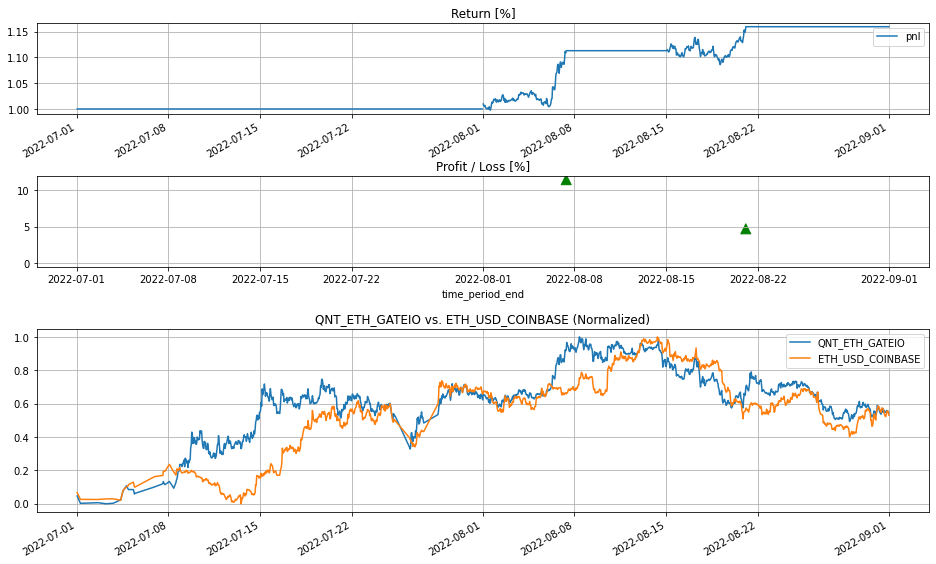

In [138]:
p.visualize_results()

In [131]:
p.trades

,entry_date,exit_date,QNT_ETH_GATEIO,ETH_USD_COINBASE,pnl,pnl_pct
0,2022-07-14 18:00:00,2022-07-31 14:00:00,52.047623,4.140388,-1592.343117,-0.160843
1,2022-08-01 05:00:00,2022-09-01 00:00:00,47.476347,2.919321,46.480294,0.004695


In [134]:
stats_for_strat.loc['_strategy', 0]

<Strategy PairsTrading(z_window=168,hedge_ratio_window=48,z_thresh_upper=2.0,z_thresh_lower=-2.0)>